In [1]:
%config InlineBackend.figure_format = 'svg'

In [2]:
import genjax
from dataclasses import dataclass
from genjax import dippl
from genjax import gensp
from genjax import select, dirac
import equinox as eqx
import optax
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import config
import adevjax
from datasets import *
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

config.update("jax_debug_nans", True)
console = genjax.pretty(show_locals=False)
key = jax.random.PRNGKey(314159)

# Plotting.
sns.set_theme(style="white")

# Data.
train_images, _, _, _ = mnist()
train_images = jnp.where(train_images > 0.5, 1.0, 0.0)


def dataloader(image_array, batch_size):
    dataset_size = len(train_images)
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield image_array[batch_perm]
            start = end
            end = start + batch_size

I0000 00:00:1696430900.246444   29654 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


## Visualize some of the data examples

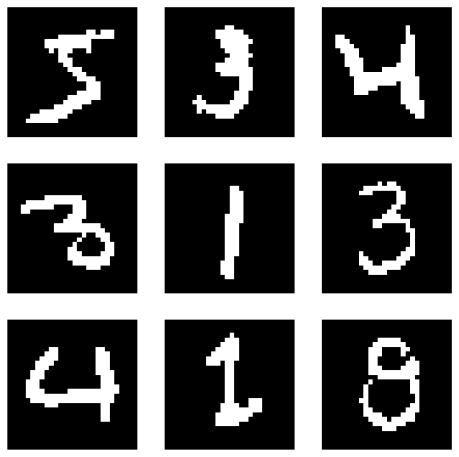

In [3]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))
counter = 0
for (i, j) in itertools.product(range(0, 3), range(0, 3)):
    sub_axis = axs[i, j]
    sub_axis.set_axis_off()
    sub_axis.imshow(train_images[counter].reshape(28, 28) / 255.0, cmap="gray")
    counter += 10

## Gradients using `DIPPL`

In [4]:
@genjax.gen
def decoder_model(decoder):
    latent = dippl.mv_normal_diag_reparam(jnp.zeros(10), jnp.ones(10)) @ "latent"
    image = decoder(latent)
    noisy_image = dippl.mv_normal_diag_reparam(image, jnp.ones(784)) @ "image"


@genjax.gen
def encoder_model(encoder, chm):
    image = chm.get_leaf_value()["image"]
    μ, Σ_diag = encoder(image)
    x = dippl.mv_normal_diag_reparam(μ, jnp.ones_like(μ)) @ "latent"


decoder_model = gensp.choice_map_distribution(
    decoder_model, select("latent", "image"), None
)
encoder_model = gensp.choice_map_distribution(encoder_model, select("latent"), None)

# Define our gradient estimator using our loss language.
def variational_value_and_grad(
    key,
    data,
    encoder,
    decoder,
):
    v_chm = genjax.value_choice_map(genjax.choice_map({"image": data}))

    @dippl.loss
    def vae_loss(encoder, decoder):
        v = dippl.upper(encoder_model)(encoder, v_chm)
        merged = gensp.merge(v, v_chm)
        dippl.lower(decoder_model)(merged, decoder)

    return vae_loss.value_and_grad_estimate(key, (encoder, decoder))


def minibatch_value_and_grad(key, data, encoder, decoder):
    sub_keys = jax.random.split(key, len(data))
    loss, (encoder_grad, decoder_grad) = jax.vmap(
        variational_value_and_grad, in_axes=(0, 0, None, None)
    )(sub_keys, data, encoder, decoder)
    encoder_grad, decoder_grad = jtu.tree_map(
        lambda v: jnp.mean(v, axis=0), (encoder_grad, decoder_grad)
    )
    loss = jnp.mean(loss)
    return loss, (encoder_grad, decoder_grad)

## Encoder/decoder architectures

In [5]:
@dataclass
class EncoderNetwork(genjax.Pytree):
    latent_dim: genjax.typing.Int
    layers: genjax.typing.List

    def flatten(self):
        return (self.layers,), (self.latent_dim,)

    def new(key, latent_dim):
        key, sub_key = jax.random.split(key)
        conv_1 = eqx.nn.Conv2d(
            in_channels=1, out_channels=32, kernel_size=3, stride=(2, 2), key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_2 = eqx.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=(2, 2), key=sub_key
        )
        dense = eqx.nn.Linear(
            in_features=2304, out_features=latent_dim + latent_dim, key=key
        )
        layers = [conv_1, conv_2, dense]
        return EncoderNetwork(latent_dim, layers)

    def __call__(self, v):
        v = v.reshape(1, 28, 28)
        for layer in self.layers[:-1]:
            v = jax.nn.relu(layer(v))
        v = v.flatten()
        v = self.layers[-1](v)  # Dense
        mu = v[0 : self.latent_dim]
        sigma = v[self.latent_dim :]
        return mu, jnp.exp(0.5 * sigma)


@dataclass
class DecoderNetwork(genjax.Pytree):
    layers: genjax.typing.List

    def flatten(self):
        return (self.layers,), ()

    def new(key, latent_dim):
        key, sub_key = jax.random.split(key)
        dense = eqx.nn.Linear(
            in_features=latent_dim, out_features=6 * 6 * 32, key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_tr_1 = eqx.nn.ConvTranspose2d(
            in_channels=32, out_channels=64, kernel_size=3, stride=2, key=sub_key
        )
        key, sub_key = jax.random.split(key)
        conv_tr_2 = eqx.nn.ConvTranspose2d(
            in_channels=64, out_channels=32, kernel_size=3, stride=2, key=sub_key
        )
        conv_tr_3 = eqx.nn.ConvTranspose2d(
            in_channels=32, out_channels=1, kernel_size=2, stride=1, key=key
        )
        layers = [dense, conv_tr_1, conv_tr_2, conv_tr_3]
        return DecoderNetwork(layers)

    def __call__(self, v):
        v = jax.nn.relu(self.layers[0](v))
        v = v.reshape(32, 6, 6)
        for layer in self.layers[1:]:
            v = jax.nn.relu(layer(v))
        v = v.reshape(784)
        return v

## Training

In [6]:
key = jax.random.PRNGKey(314159)
learning_rate = 1e-3
iter_data = dataloader(train_images, 64)
key, sub_key = jax.random.split(key)
encoder_net = EncoderNetwork.new(sub_key, 10)
key, sub_key = jax.random.split(key)
decoder_net = DecoderNetwork.new(sub_key, 10)
steps = 100000


@jax.jit
def make_step(key, encoder_net, decoder_net, data, opt_state):
    loss, grads = minibatch_value_and_grad(key, data, encoder_net, decoder_net)
    grads = jtu.tree_map(lambda v: -v, grads)
    updates, opt_state = optim.update(grads, opt_state)
    encoder_net, decoder_net = eqx.apply_updates((encoder_net, decoder_net), updates)
    mean_grad = jnp.mean(jnp.array(jtu.tree_leaves(jtu.tree_map(jnp.mean, grads))))
    return loss, (encoder_net, decoder_net), opt_state, mean_grad


optim = optax.adam(learning_rate)
opt_state = optim.init((encoder_net, decoder_net))
for step, image_batch in tqdm(zip(range(steps), iter_data)):
    key, sub_key = jax.random.split(key)
    loss, (encoder_net, decoder_net), opt_state, mean_grad = make_step(
        sub_key, encoder_net, decoder_net, image_batch, opt_state
    )
    loss = loss.item()
    if step % 1000 == 0:
        print(loss)

29it [00:02, 15.18it/s]

-767.2025146484375


1048it [00:06, 263.99it/s]

-751.7760009765625


2043it [00:10, 270.48it/s]

-749.65087890625


3048it [00:13, 276.21it/s]

-751.0823974609375


4045it [00:17, 262.52it/s]

-749.9981079101562


5038it [00:21, 269.34it/s]

-750.1190185546875


6048it [00:25, 276.12it/s]

-750.2573852539062


7052it [00:28, 284.89it/s]

-749.4620361328125


8030it [00:32, 268.84it/s]

-748.8131713867188


9042it [00:35, 276.06it/s]

-749.48974609375


10050it [00:39, 281.45it/s]

-748.350830078125


11040it [00:43, 271.35it/s]

-749.4078369140625


12044it [00:46, 261.61it/s]

-748.7908325195312


13052it [00:50, 278.22it/s]

-751.2282104492188


14049it [00:54, 264.83it/s]

-750.8150634765625


15048it [00:58, 261.60it/s]

-750.4269409179688


16051it [01:01, 290.21it/s]

-748.9052734375


17040it [01:05, 274.26it/s]

-747.9483642578125


18038it [01:08, 296.60it/s]

-749.7037353515625


19037it [01:12, 296.46it/s]

-749.4363403320312


20051it [01:15, 296.49it/s]

-750.3103637695312


21035it [01:18, 277.64it/s]

-748.1875


22038it [01:22, 289.86it/s]

-751.3282470703125


23047it [01:26, 269.38it/s]

-749.2526245117188


24028it [01:29, 264.94it/s]

-749.9317016601562


25054it [01:33, 274.36it/s]

-751.2203979492188


26039it [01:37, 264.69it/s]

-749.6110229492188


27035it [01:40, 265.07it/s]

-750.0661010742188


28042it [01:44, 267.05it/s]

-750.8037109375


29041it [01:48, 269.75it/s]

-748.8677978515625


30044it [01:52, 273.94it/s]

-747.790283203125


31054it [01:55, 265.88it/s]

-748.1328125


32051it [01:59, 267.95it/s]

-749.4312744140625


33043it [02:03, 270.21it/s]

-749.5054321289062


34038it [02:06, 289.65it/s]

-751.21435546875


35046it [02:10, 262.89it/s]

-750.3896484375


36053it [02:14, 274.51it/s]

-749.5843505859375


37054it [02:17, 280.09it/s]

-748.2052001953125


38019it [02:22, 196.82it/s]

-748.91748046875


39032it [02:28, 287.75it/s]

-749.6690673828125


40057it [02:31, 282.57it/s]

-749.2127685546875


41047it [02:35, 289.00it/s]

-747.872802734375


42037it [02:38, 283.73it/s]

-750.9304809570312


43056it [02:41, 289.01it/s]

-750.173583984375


44049it [02:45, 280.05it/s]

-749.8385620117188


45039it [02:48, 284.36it/s]

-749.212890625


46045it [02:52, 285.91it/s]

-749.7686767578125


47049it [02:55, 288.73it/s]

-750.705810546875


48038it [02:59, 287.77it/s]

-750.396728515625


49033it [03:02, 287.37it/s]

-748.672119140625


50037it [03:06, 292.57it/s]

-749.2996215820312


51057it [03:09, 288.55it/s]

-751.0792236328125


52045it [03:13, 290.35it/s]

-749.1444091796875


53051it [03:16, 283.62it/s]

-750.29443359375


54038it [03:20, 276.36it/s]

-748.8035278320312


55040it [03:23, 269.42it/s]

-749.7959594726562


56038it [03:27, 275.05it/s]

-749.066650390625


57054it [03:31, 274.34it/s]

-749.6207275390625


58048it [03:34, 264.78it/s]

-751.4994506835938


59057it [03:38, 279.33it/s]

-752.125


60047it [03:42, 271.45it/s]

-750.0670166015625


61049it [03:46, 273.38it/s]

-750.8950805664062


62043it [03:49, 259.78it/s]

-749.9185791015625


63038it [03:53, 273.77it/s]

-747.917236328125


64046it [03:57, 263.41it/s]

-749.4739379882812


65044it [04:00, 276.23it/s]

-748.9769287109375


66055it [04:04, 274.53it/s]

-749.5928955078125


67058it [04:08, 296.73it/s]

-750.1368408203125


68042it [04:11, 286.42it/s]

-750.2476806640625


69035it [04:15, 287.17it/s]

-751.00927734375


70016it [04:21, 81.25it/s] 

-749.88916015625


71039it [04:25, 272.80it/s]

-750.1390380859375


72041it [04:29, 290.36it/s]

-750.097900390625


73045it [04:32, 288.88it/s]

-749.8819580078125


74037it [04:35, 275.70it/s]

-749.8455810546875


75050it [04:39, 297.50it/s]

-749.4696044921875


76052it [04:42, 286.74it/s]

-751.00341796875


77057it [04:46, 288.42it/s]

-750.9437255859375


78052it [04:49, 287.25it/s]

-748.8402099609375


79041it [04:53, 290.06it/s]

-750.2039184570312


80043it [04:56, 290.11it/s]

-749.6697998046875


81057it [05:00, 290.39it/s]

-750.3023681640625


82047it [05:03, 290.97it/s]

-749.061767578125


83059it [05:07, 289.87it/s]

-748.509765625


84054it [05:10, 289.46it/s]

-747.7459716796875


85032it [05:14, 290.58it/s]

-748.110595703125


86033it [05:17, 273.17it/s]

-748.38232421875


87041it [05:21, 272.47it/s]

-750.746337890625


88035it [05:24, 291.22it/s]

-751.8325805664062


89059it [05:28, 291.66it/s]

-749.384033203125


90042it [05:31, 289.12it/s]

-748.9150390625


91039it [05:35, 280.70it/s]

-748.731689453125


92052it [05:38, 277.30it/s]

-748.4453125


93041it [05:42, 289.31it/s]

-749.4893798828125


94043it [05:45, 282.82it/s]

-750.3700561523438


95049it [05:49, 267.06it/s]

-749.5472412109375


96035it [05:53, 288.95it/s]

-750.5307006835938


97052it [05:56, 285.10it/s]

-750.2467041015625


98054it [06:00, 284.56it/s]

-749.4952392578125


99042it [06:03, 290.05it/s]

-751.4676513671875


100000it [06:06, 272.51it/s]


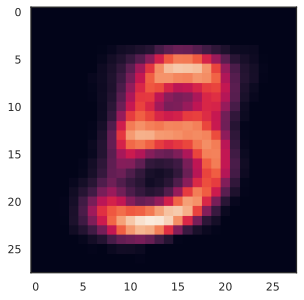

In [14]:
key, sub_key = jax.random.split(key)
latent = genjax.tfp_mv_normal_diag.sample(sub_key, jnp.zeros(10), jnp.ones(10))
plt.imshow(decoder_net(latent).reshape(28, 28))